# Finetuning

Create custom dataset + finetune a bert model on it

## Structure

- `drive/MyDrive/Colab Notebooks/nlp2/NLPA-main.zip` is the zipped repo

---

In [ ]:
![ -e "staqc_man_python_codegen.hf" ] || unzip drive/MyDrive/"Colab Notebooks/nlp2 (1)"/staqc*.zip > /dev/null
# !unzip drive/MyDrive/"Colab Notebooks/nlp2 (1)"/staqc*.zip > /dev/null

---

In [ ]:
!pip install datasets 'transformers[torch]' evaluate accelerate -q

---

In [ ]:
!rm -rf saved_model training.zip test_trainer

In [ ]:
from datasets import load_dataset, concatenate_datasets, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainerCallback
import matplotlib.pyplot as plt

In [ ]:
# dataset = load_from_disk('staqc_man_python_codegen.hf')
# dataset = load_from_disk('staqc_man_python_codegen_source.hf')
dataset = load_from_disk('staqc_man_python_codegen_comments.hf')
print(dataset)
print(dataset['train'][0]['text'])

DatasetDict({
    train: Dataset({
        features: ['question_id', 'question', 'text', 'label'],
        num_rows: 2008
    })
    test: Dataset({
        features: ['question_id', 'question', 'text', 'label'],
        num_rows: 77
    })
})
# this is the root factory, you can set an __acl__ here for all resources
# set ACL here for *all* objects of type Foo
# get a database connection
# this __acl__ is computed dynamically based on the specific object
# allow any authenticated user to view Bar objects


In [ ]:
# TODO : Change tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# small_train_dataset = dataset["train"].shuffle(seed=42).select(range(500)).map(tokenize_function, batched=True)
small_train_dataset = dataset["train"].shuffle(seed=42).map(tokenize_function, batched=True)
# small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(100)).map(tokenize_function, batched=True)
small_eval_dataset = dataset["test"].shuffle(seed=42).map(tokenize_function, batched=True)

# small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000)).map(tokenize_function, batched=True)
# small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000)).map(tokenize_function, batched=True)

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 16
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", per_device_train_batch_size=batch_size,)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
train_history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.679910,0.168831
2,No log,0.946335,0.584416
3,No log,2.215430,0.428571


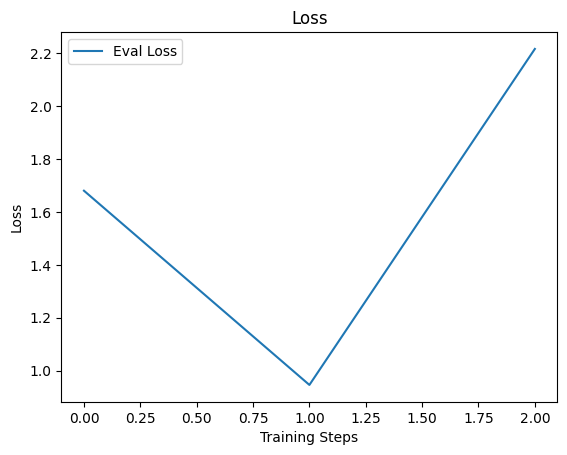

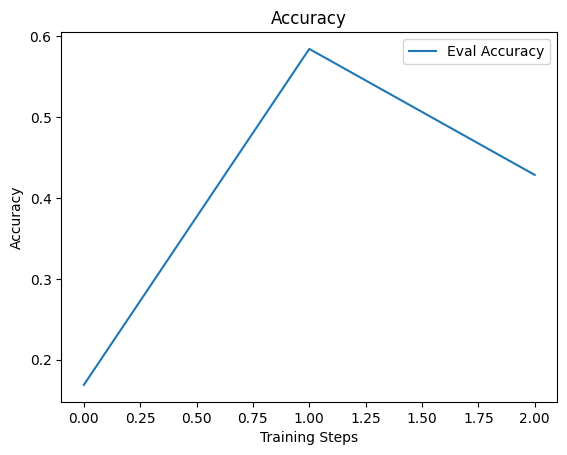

In [ ]:
eval_losses = []
for log in trainer.state.log_history:
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

eval_accuracies = []
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        eval_accuracies.append(log['eval_accuracy'])

plt.title("Loss")
plt.plot(eval_losses, label="Eval Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Accuracy")
plt.plot(eval_accuracies, label="Eval Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Save everything
model.save_pretrained("./saved_model")
trainer.save_model("./saved_model/trainer")
tokenizer.save_pretrained("./saved_model")
!rm -f training.zip && zip -r training.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/tokenizer_config.json (deflated 76%)
  adding: saved_model/tokenizer.json (deflated 70%)
  adding: saved_model/vocab.txt (deflated 49%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/trainer/ (stored 0%)
  adding: saved_model/trainer/model.safetensors (deflated 7%)
  adding: saved_model/trainer/config.json (deflated 49%)
  adding: saved_model/trainer/training_args.bin (deflated 51%)
  adding: saved_model/config.json (deflated 49%)
